# Inverse Kinematics (2D)
with https://github.com/google/jax

*note*
* running on GPU with colab: https://colab.research.google.com/drive/1guZnXsFOEVLb7IOXVzUgRc8pbq3Z50Qf

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt
from numpy import random, pi
from __future__ import division
from IPython import display
from ipywidgets import interact, fixed

import jax.numpy as np
from jax import grad, jit

## Coordinate Transformation

In [2]:
def trans(x, y, a):
    '''create a 2D transformation'''
    s = np.sin(a)
    c = np.cos(a)
    return np.asarray([[c, -s, x],
                       [s,  c, y],
                       [0,  0, 1]])

def from_trans(m):
    '''get x, y, theta from transform matrix'''
    a = np.arctan2(m[1, 0], m[0, 0])
    return np.asarray([m[0, -1], m[1, -1], a])

In [3]:
print(trans(0., 0., 0.))

[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


/home/xu/miniconda3/envs/robocup/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Parameters of robot arm

In [4]:
l = [0, 3, 2, 1]
#l = [0, 3, 2, 1, 1]
#l = [0, 3, 2, 1, 1, 1]
#l = [1] * 30
N = len(l) - 1  # number of links
max_len = sum(l)
a = random.random_sample(N)  # angles of joints
T0 = trans(0, 0, 0)  # base

## Forward Kinematics

In [5]:
def forward_kinematics(T0, l, a):
    T = [T0]
    for i in range(len(a)):
        Ti = np.dot(T[-1], trans(l[i], 0, a[i]))
        T.append(Ti)
    Te = np.dot(T[-1], trans(l[-1], 0, 0))  # end effector
    T.append(Te)
    return T

In [6]:
def show_robot_arm(T):
    plt.cla()
    x = [Ti[0,-1] for Ti in T]
    y = [Ti[1,-1] for Ti in T]
    plt.plot(x, y, '-or', linewidth=5, markersize=10)
    plt.plot(x[-1], y[-1], 'og', linewidth=5, markersize=10)
    plt.xlim([-max_len, max_len])
    plt.ylim([-max_len, max_len]) 
    ax = plt.axes()
    ax.set_aspect('equal')
    t = np.arctan2(T[-1][1, 0], T[-1][0,0])
    ax.annotate('[%.2f,%.2f,%.2f]' % (x[-1], y[-1], t), xy=(x[-1], y[-1]), xytext=(x[-1], y[-1] + 0.5))
    plt.show
    return ax

## Inverse Kinematics

### Numerical Solution: jax

<IPython.core.display.Javascript object>


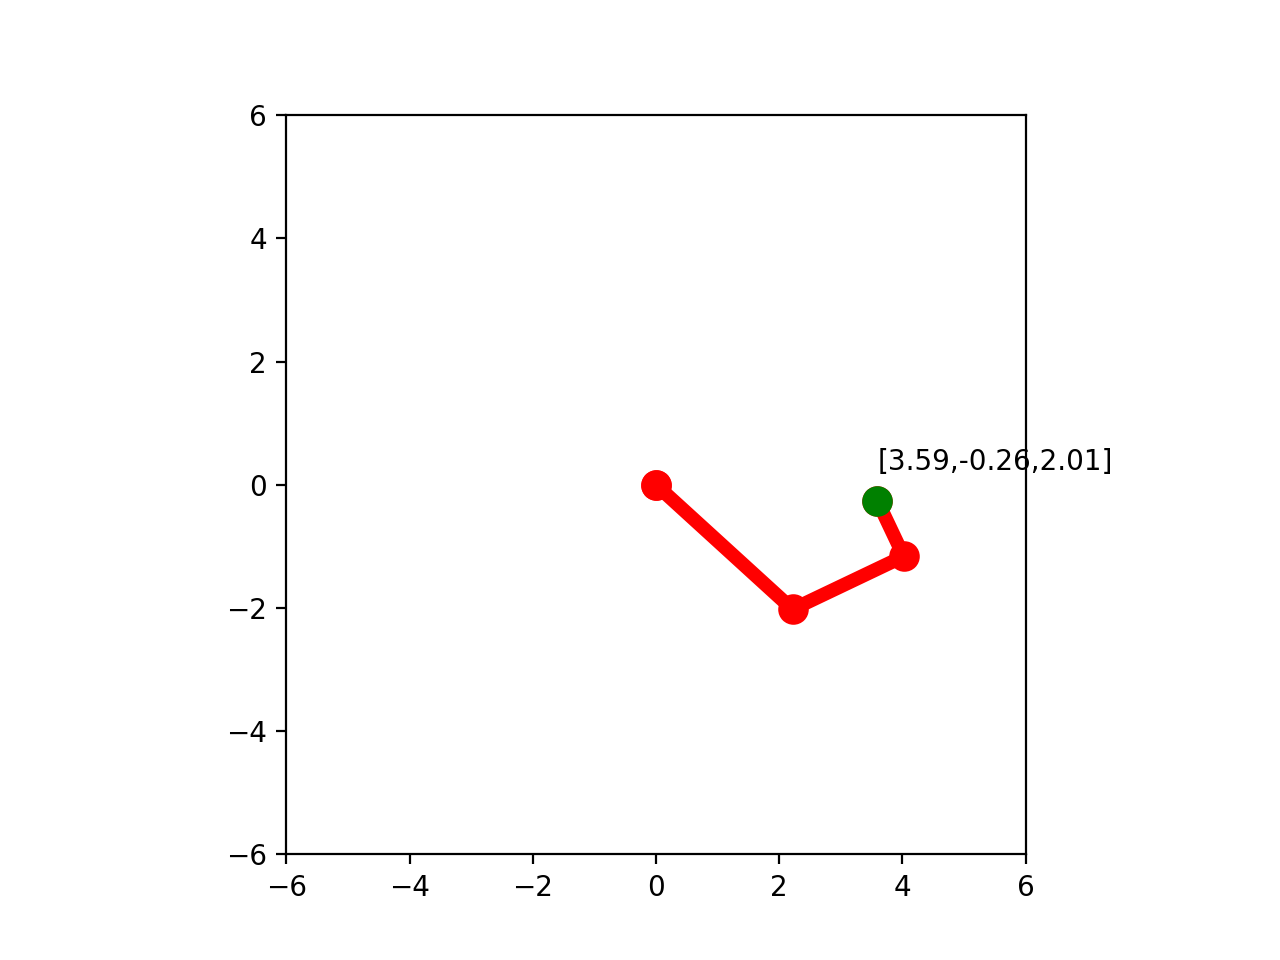

<ipython-input-6-d35263df4e47>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


interactive(children=(FloatSlider(value=4.991220474243164, description='x_e', max=6.0, step=0.01), FloatSlider…

In [7]:
def error_func(theta, target):
    Ts = forward_kinematics(T0, l, theta)
    Te = Ts[-1]
    e = target - Te
    return np.sum(e * e)

theta = random.random(N)
def inverse_kinematics(x_e, y_e, theta_e, theta):
    target = trans(x_e, y_e, theta_e)
    func = lambda t: error_func(t, target)
    func_grad = jit(grad(func))
    
    for i in range(1000):
        e = func(theta)
        d = func_grad(theta)
        theta -= d * 1e-2
        if e < 1e-4:
            break
    
    return theta

T = forward_kinematics(T0, l, theta)
show_robot_arm(T)
Te = np.asarray([from_trans(T[-1])])

@interact(x_e=(0, max_len, 0.01), y_e=(-max_len, max_len, 0.01), theta_e=(-pi, pi, 0.01), theta=fixed(theta))
def set_end_effector(x_e=Te[0,0], y_e=Te[0,1], theta_e=Te[0,2], theta=theta):
    theta = inverse_kinematics(x_e, y_e, theta_e, theta)
    T = forward_kinematics(T0, l, theta)
    show_robot_arm(T)
    return theta
